# Review Sentiment Using Natural Language Processing

## Buisiness Problem
An online publication group would like to use twitter data as a tool to help inform their writers as to which subjects are of interest to those who use that platform. The goal is to be able to use the twitter API to pull tweets on a given subject, describe the overall sentiment of the tweet, and determine which words are most commonly used within those categroies. The result should help writers narrow down their research enabling them to more efficiently produce content that will generate interest and focus on the most relevent subjects. This project is meant to be a proof of concept centered around the SXSW conference, specifically tweets about Google and Apple who both tend to have a huge presence at the event. Typically this consists releasing new products, hosting events, and inviting guest speakers.  

In [461]:
#importing relevent libraries

import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from nltk import FreqDist

In [462]:
data=pd.read_csv("Data/tweet_data.csv", encoding="latin-1") 
data.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


## Initial Data Exploration

data=pd.read_csv("Data/tweet_data.csv", encoding="latin-1")
data.tail(10)

In [463]:
#These column names, while very descriptive, need to be more user friendly
data = data.rename(columns = {'tweet_text':'text',
                              'emotion_in_tweet_is_directed_at':'product',
                              'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'})

In [464]:
data['product'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [465]:
#For our purposes we will just look at brands and can focus on individual products later
prod_replace_dict = {
                     'iPhone':'Apple',
                     'iPad':'Apple',
                     'iPad or iPhone App':'Apple',
                     'Other Apple product or service':'Apple',
                     'Android':'Google',
                     'Android App':'Google',
                     'Other Google product or service':'Google'
}

In [466]:
data['product'] = data['product'].replace(prod_replace_dict)

### Distributions

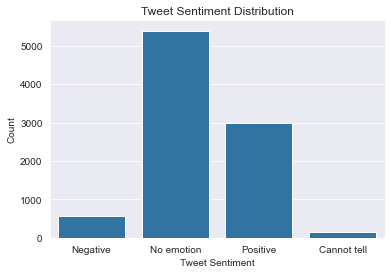

In [467]:
fig, ax = plt.subplots()

classes = ['Negative emotion', 'No emotion toward brand or product', 'Positive emotion', "I can't tell"]
sns.countplot(x=data['sentiment'], data = data, color='tab:blue', order=classes)

ax.set(xticklabels=['Negative', 'No emotion', 'Positive', 'Cannot tell'], 
       xlabel='Tweet Sentiment', ylabel='Count', title='Tweet Sentiment Distribution');

#

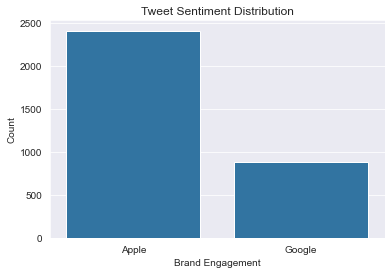

In [468]:
fig, ax = plt.subplots()

classes = ['Apple', 'Google']
sns.countplot(x=data['product'], data = data, color='tab:blue', order=classes)

ax.set(xticklabels=['Apple', 'Google'], 
       xlabel='Brand Engagement', ylabel='Count', title='Tweet Sentiment Distribution');
#It looks like there are a large majority of tweets that arent directed at either of our brands

In [469]:
data.isna().sum()

text            1
product      5802
sentiment       0
dtype: int64

In [470]:
data[data['product'].isnull()]
#from a quick glance we can see that some of these tweets definitely pertain to our business problem.

,text,product,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [471]:
data['text'] = data['text'].str.lower()
data.head()

#we can standardize case here without causing data leakage

,text,product,sentiment
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Apple,Negative emotion
1,@jessedee know about @fludapp ? awesome ipad/i...,Apple,Positive emotion
2,@swonderlin can not wait for #ipad 2 also. the...,Apple,Positive emotion
3,@sxsw i hope this year's festival isn't as cra...,Apple,Negative emotion
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion


In [472]:
#We can drop the single NaN value in the text column, which is necessary for this next step to work
data.dropna(subset=['text'], inplace = True)
data.reset_index(drop=True, inplace=True)

In [473]:
#preliminary count prior to reclassifying tweets
data['product'].value_counts()

Apple     2409
Google     882
Name: product, dtype: int64

In [474]:
#this block of code will classify any tweet mentioning a specific product as such
google_words = ['android', '#google', 'google']
apple_words = ['iphone', 'ipad', 'mac', 'apple', '#apple']

for index in range(len(data)):
    if (any(word in data['text'][index] for word in google_words) == True):
        data['product'][index] = 'Google'
    else:
        pass
for index in range(len(data)):
    if (any(word in data['text'][index] for word in apple_words) == True):
        data['product'][index] = 'Apple'
    else:
        pass

In [475]:
#this leaves us with a much higher number of tweets to work with
data['product'].value_counts()

Apple     5569
Google    2767
Name: product, dtype: int64

In [476]:
null=data.loc[data['product'].isnull() == True]
null.head()

,text,product,sentiment
50,ûï@mention {link} &lt;-- help me forward this...,NaN,No emotion toward brand or product
51,÷¼ what? ÷_ {link} ã_ #edchat #musedchat #s...,NaN,No emotion toward brand or product
52,.@mention @mention on the location-based 'fast...,NaN,No emotion toward brand or product
65,at #sxsw? @mention / @mention wanna buy you a ...,NaN,No emotion toward brand or product
70,chilcott: @mention #sxsw stand talking with bl...,NaN,No emotion toward brand or product


In [477]:
print(len(null))

#These tweets likely don't pertain to our products and aren't useful for our model

756


In [478]:
data = data.dropna(axis=0)

In [479]:
data = data[data['sentiment'] != "I can't tell"]
data['sentiment'].value_counts()
#With so few "I can't tell" values, it doesnt make sense to classify them
#With such a large class imbalance, it makes sense to stratify our train and test sets

No emotion toward brand or product    4652
Positive emotion                      2965
Negative emotion                       569
Name: sentiment, dtype: int64

In [480]:
apple_df = data[data['product'] == 'apple']
google_df = data[data['product'] == 'google']

In [300]:
X = data.drop('sentiment', axis=1)
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, stratify=y)

In [301]:
X_train

,text,product
3675,over 100 in line at apple pop-up store; everyo...,Apple
8699,we interrupt your regularly-scheduled #sxsw ge...,Google
8071,what a dissapointment!!! rt @mention new #uber...,Apple
8614,no more stumbling around lost at #sxsw! stay i...,Apple
1049,congrats! rt @mention good news! austin eats: ...,Apple
...,...,...
6659,rt @mention smart company. rt @mention it's no...,Apple
2837,just picked up a backup iphone battery charger...,Apple
8013,ûïthe classiest fascist company in existence...,Apple
2681,did google just buy foursquare? &quot;i don't ...,Google


In [302]:
train_text = X_train['text']
test_text = X_test['text']

In [308]:
#This block of code will retun all groupings beginning with @ and containing all allowable twitter username characters

for line in train_text:    
    p = re.findall(r'@([A-Za-z0-9_]+)', line)
    if p != 0:
        print(p)

[]
['mention']
['mention']
['mention']
['mention']
['mention']
[]
[]
[]
['mention']
['mention']
['mention']
[]
['mention']
['mention', 'mention']
[]
['mention', 'mention']
['mention']
[]
['mention', 'mention', 'mention']
['mention']
['mention']
[]
[]
[]
['mention', 'mention']
['mention']
['mention', 'mention']
[]
['mention']
['mention']
['mention', 'mention']
['mention', 'mention', 'mention']
['mention']
[]
[]
['mention']
['mention']
['mention']
[]
['mention']
['mention']
['mention']
[]
['mention']
['mention']
['mention']
['mention']
['mention']
['mention']
['mention']
[]
['mention', 'mention']
[]
['mention']
[]
[]
['mention']
['mention']
['mention']
[]
[]
['mention']
[]
['mention']
[]
['mention', 'mention']
[]
[]
['mention', 'mention', 'mention']
['mention']
['mention']
['mention', 'mention']
[]
[]
[]
[]
[]
['mention']
[]
[]
[]
[]
[]
[]
['mention']
['mention']
['mention']
['mention']
['mention']
['mention']
[]
['mention', 'mention', 'mention']
[]
['mention']
[]
[]
[]
['mention']
[]
['

In [311]:
for line in train_text:    
    new_line = re.sub(r'@([A-Za-z0-9_]+)','', line)
    train_text.replace(line, new_line, inplace=True)      
    
for line in test_text:
    new_line = re.sub(r'@([A-Za-z0-9_]+)','', line)
    train_text.replace(line, new_line, inplace=True)

In [481]:
train_text.head()

3675    over 100 in line at apple pop-up store; everyo...
8699    we interrupt your regularly-scheduled #sxsw ge...
8071    what a dissapointment!!! rt  new #ubersocial f...
8614    no more stumbling around lost at #sxsw! stay i...
1049    congrats! rt  good news! austin eats: bbq for ...
Name: text, dtype: object

In [482]:
for line in train_text:
    new_line = line.translate(str.maketrans('', '', string.punctuation))
    train_text.replace(line, new_line, inplace=True)

for line in test_text:
    new_line = line.translate(str.maketrans('', '', string.punctuation))

In [355]:
text_data

0       i have a 3g iphone after 3 hrs tweeting at ris...
1       know about   awesome ipadiphone app that youll...
2       can not wait for ipad 2 also they should sale ...
3       i hope this years festival isnt as crashy as t...
4       great stuff on fri sxsw marissa mayer google t...
                              ...                        
9088                            ipad everywhere sxsw link
9089    wave buzz rt  we interrupt your regularly sche...
9090    googles zeiger a physician never reported pote...
9091    some verizon iphone customers complained their...
9092    ï¡ïàüêîò£áââ£âûârt  goo...
Name: text, Length: 8336, dtype: object

In [325]:
train_text.str.split()
test_text.str.split()

3065    [in, the, press, lounge, of, #sxsw,, someone, ...
2969    [inline, @mention, the, apple, popup, waiting,...
2086    [@mention, arg., it, won't, load, on, me, ipho...
3040    [ipad, 2, goes, on, sale, at, 3, pm, at, #sxsw...
4682    [like, a, venn, diagram, ?, &quot;@mention, go...
                              ...                        
404     [ipad, 2, is, coming, out, at, #sxsw,, guess, ...
7448    [the, bad, apple, shows, up, late, shoots, dow...
2804    [&quot;facebook, and, google, are, our, bigges...
5099    [rt, @mention, @mention, @mention, check, this...
4690    [@mention, no, iphone?, no, worries., drop, in...
Name: text, Length: 1815, dtype: object

In [483]:
# Create new column with tokenized data
X_train["text_tokenized"] = train_text.apply(tokenizer.tokenize)
# Display full text
X_train['text_tokenized']

3675    [over, 100, in, line, at, apple, popup, store,...
8699    [we, interrupt, your, regularlyscheduled, sxsw...
8071    [what, dissapointment, rt, new, ubersocial, fo...
8614    [no, more, stumbling, around, lost, at, sxsw, ...
1049    [congrats, rt, good, news, austin, eats, bbq, ...
                              ...                        
6659    [rt, smart, company, rt, its, not, rumor, appl...
2837    [just, picked, up, backup, iphone, battery, ch...
8013    [ûïthe, classiest, fascist, company, in, exist...
2681    [did, google, just, buy, foursquare, quoti, do...
4972    [ben, at, google, think, while, making, as, fa...
Name: text_tokenized, Length: 5443, dtype: object

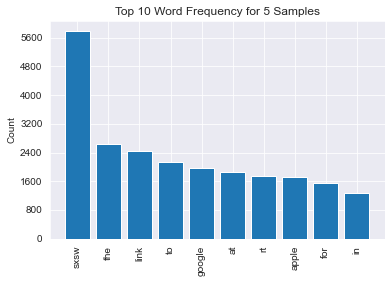

In [410]:
X_train["text_tokenized"].explode()
X_train_freq_dist = FreqDist(X_train["text_tokenized"].explode())
visualize_top_10(X_train_freq_dist, "Top 10 Word Frequency for 5 Samples")

In [411]:

# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out())

,apple,at,for,google,in,link,rt,sxsw,the,to
0,0.370257,0.711938,0.391716,0.000000,0.419097,0.000000,0.000000,0.164223,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.709646,0.000000,0.618586,0.000000,0.337273,0.000000,0.000000
2,0.000000,0.000000,0.463505,0.000000,0.495904,0.000000,0.436491,0.194319,0.380351,0.407787
3,0.000000,0.492049,0.000000,0.000000,0.579309,0.416339,0.000000,0.227001,0.444321,0.000000
4,0.000000,0.000000,0.613852,0.000000,0.000000,0.472002,0.578075,0.257351,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
5438,0.363512,0.000000,0.384581,0.000000,0.411463,0.000000,0.724333,0.161231,0.000000,0.000000
5439,0.000000,0.702166,0.000000,0.000000,0.000000,0.000000,0.000000,0.323937,0.634057,0.000000
5440,0.635264,0.000000,0.000000,0.000000,0.719062,0.000000,0.000000,0.281763,0.000000,0.000000
5441,0.000000,0.000000,0.000000,0.903183,0.000000,0.000000,0.000000,0.429255,0.000000,0.000000


In [412]:
baseline_model = MultinomialNB()

baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

array([0.5399449 , 0.52800735, 0.53259871, 0.52665441, 0.53125   ])

In [416]:
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords


def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [423]:
tokens_example = X_train.iloc[100]["text_tokenized"]
remove_stopwords(tokens_example)

['win',
 'awesome',
 'ipad',
 'quibids',
 'custom',
 'case',
 'catch',
 'sxsw',
 'wearing',
 'openbeta',
 'vip',
 'badge']

In [424]:
X_train["text_without_stopwords"] = X_train["text_tokenized"].apply(remove_stopwords)

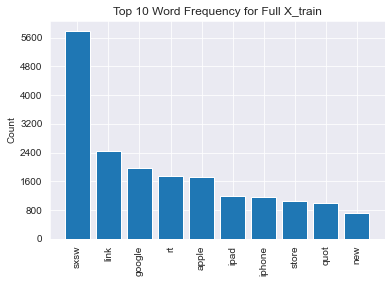

In [425]:

# Create a frequency distribution for X_train
train_freq_dist = FreqDist(X_train["text_without_stopwords"].explode())

# Plot the top 10 tokens
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for Full X_train")

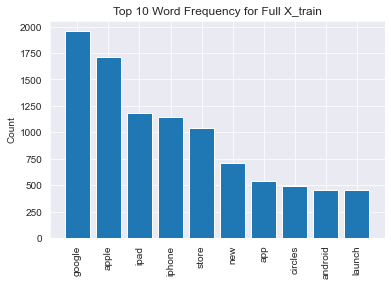

In [427]:
sxsw_list = ['sxsw', 'rt', 'link', 'quot', 'austin', 'amp']
def remove_sxsw(token_list):
    sxsw_removed = [token for token in token_list if token not in sxsw_list]
    return sxsw_removed

X_train["text_without_stopwords"] = X_train["text_without_stopwords"].apply(remove_sxsw)

# Create a frequency distribution for X_train
train_freq_dist = FreqDist(X_train["text_without_stopwords"].explode())

# Plot the top 10 tokens
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for Full X_train")